In [1]:
# Imports + Paths + DuckDB connect + Load assignment parquet

import duckdb
import numpy as np
import pandas as pd
from pathlib import Path

DATA_DIR = Path("../data")
SALT = "checkout_ui_v1"
ASSIGN_PATH = DATA_DIR / f"assignment_{SALT}.parquet"
SEG_PATH = DATA_DIR / "user_segment.csv"

assert ASSIGN_PATH.exists(), f"Missing: {ASSIGN_PATH}"

con = duckdb.connect(database=":memory:")

con.execute(f"""
CREATE OR REPLACE VIEW assignment AS
SELECT *
FROM read_parquet('{ASSIGN_PATH.as_posix()}')
""")

con.execute("SELECT COUNT(*) AS n FROM assignment").df()


,n
0,5316128


In [3]:
# Load REAL segments + Build base view（New/Returning from user_type）

# Load user_segment if exists; keep pipeline stable if missing
if SEG_PATH.exists():
    con.execute(f"""
    CREATE OR REPLACE VIEW user_segment AS
    SELECT
      CAST("user_id" AS BIGINT) AS user_id,
      CAST("user_type" AS VARCHAR) AS user_type,
      "first_seen_time" AS first_seen_time
    FROM read_csv_auto('{SEG_PATH.as_posix()}', HEADER=TRUE)
    """)
    print("Loaded segments:", SEG_PATH)
else:
    con.execute("""
    CREATE OR REPLACE VIEW user_segment AS
    SELECT CAST(NULL AS BIGINT) AS user_id,
           CAST(NULL AS VARCHAR) AS user_type,
           CAST(NULL AS VARCHAR) AS first_seen_time
    WHERE FALSE
    """)
    print("⚠️ Missing user_segment.csv. Will use Unknown segment.")

# Base view: keep only what Phase 7 needs
con.execute("""
CREATE OR REPLACE VIEW base AS
SELECT
  a.user_id,
  CAST(a.variant AS INTEGER) AS variant,
  CAST(a.cart AS BOOLEAN) AS exposed,
  CAST(a.purchase AS BOOLEAN) AS purchase,
  COALESCE(s.user_type, 'Unknown') AS segment_raw
FROM assignment a
LEFT JOIN user_segment s
ON a.user_id = s.user_id
""")

# Sanity check
con.execute("""
SELECT
  COUNT(*) AS n,
  AVG(CASE WHEN exposed THEN 1 ELSE 0 END) AS exposed_rate,
  AVG(CASE WHEN purchase THEN 1 ELSE 0 END) AS purchase_rate,
  AVG(CASE WHEN segment_raw <> 'Unknown' THEN 1 ELSE 0 END) AS segment_coverage
FROM base
""").df()


Loaded segments: ..\data\user_segment.csv


,n,exposed_rate,purchase_rate,segment_coverage
0,5316128,0.198001,0.101412,1.0


In [4]:
# Phase 7 Inputs

# ---- Time window assumption ----
# 这份数据覆盖多少期？30 天
WINDOW_DAYS = 30  # 后面会自动年化

DAYS_PER_YEAR = 365
ANNUALIZE_FACTOR = DAYS_PER_YEAR / WINDOW_DAYS

# ---- Business parameters ----
AOV = 80.0  # Average Order Value, USD (可改)
# 也可以把 AOV 换成更稳健的范围（best/base/worst）做敏感性

# ---- Cost scenarios (annual) ----
COST_BEST = 20_000     # $/year
COST_BASE = 80_000
COST_WORST = 200_000

# ---- Rollout scenarios ----
# A: All users
# B: New only (更贴合 Phase 6 的异质性结论)
ROLLOUT_SCENARIOS = ["all_users", "new_only"]

(WINDOW_DAYS, AOV, ANNUALIZE_FACTOR, ROLLOUT_SCENARIOS)


(30, 80.0, 12.166666666666666, ['all_users', 'new_only'])

In [5]:
# Exposure-aware uplift simulation（只对 treated ∩ exposed ∩ not purchased 抽样翻转）

UPLIFT_PROB = 0.05   # Phase 6 用过的 uplift（示例：5% 相对提升）
SEED = 42

# Candidate: treated (variant=1) AND exposed AND purchase==False
candidates = con.execute("""
SELECT user_id
FROM base
WHERE variant = 1 AND exposed = TRUE AND purchase = FALSE
""").df()

n_cand = len(candidates)
n_cand


255778

In [6]:
# Sample flips + Build purchase_sim view
rng = np.random.default_rng(SEED)
flip_mask = rng.random(n_cand) < UPLIFT_PROB

flips = candidates.loc[flip_mask, ["user_id"]].copy()
flips["flip"] = 1

print("Candidates:", n_cand)
print("Flips:", len(flips), f"({len(flips)/max(n_cand,1):.2%} of candidates)")

con.register("flips_df", flips)

# purchase_sim: purchase OR (user_id in flips)
con.execute("""
CREATE OR REPLACE VIEW sim AS
SELECT
  b.user_id,
  b.variant,
  b.exposed,
  b.purchase,
  CASE WHEN f.flip = 1 THEN TRUE ELSE b.purchase END AS purchase_sim,
  b.segment_raw
FROM base b
LEFT JOIN flips_df f
ON b.user_id = f.user_id
""")

con.execute("""
SELECT
  COUNT(*) AS n,
  AVG(CASE WHEN purchase_sim THEN 1 ELSE 0 END) AS sim_purchase_rate
FROM sim
""").df()


Candidates: 255778
Flips: 12712 (4.97% of candidates)


,n,sim_purchase_rate
0,5316128,0.103803


In [7]:
# Compute causal metrics (ITT / CATE / Placebo) + segment uplift（Phase 7 的输入）

from statsmodels.stats.proportion import proportions_ztest
import numpy as np

def two_prop_ci(p1, p0, n1, n0, alpha=0.05):
    # Wald CI for diff p1-p0
    se = np.sqrt(p1*(1-p1)/n1 + p0*(1-p0)/n0)
    z = 1.959963984540054  # ~N(0,1) 97.5% quantile
    diff = p1 - p0
    return diff, diff - z*se, diff + z*se

# --- ITT (all users) ---
itt = con.execute("""
SELECT
  variant,
  COUNT(*) AS n_users,
  SUM(CASE WHEN purchase_sim THEN 1 ELSE 0 END) AS purchasers
FROM sim
GROUP BY variant
ORDER BY variant
""").df()

p0 = itt.loc[itt["variant"]==0, "purchasers"].iloc[0] / itt.loc[itt["variant"]==0, "n_users"].iloc[0]
p1 = itt.loc[itt["variant"]==1, "purchasers"].iloc[0] / itt.loc[itt["variant"]==1, "n_users"].iloc[0]
n0 = itt.loc[itt["variant"]==0, "n_users"].iloc[0]
n1 = itt.loc[itt["variant"]==1, "n_users"].iloc[0]

diff, ci_low, ci_high = two_prop_ci(p1, p0, n1, n0)
z, pval = proportions_ztest(count=[itt.loc[itt["variant"]==1, "purchasers"].iloc[0],
                                   itt.loc[itt["variant"]==0, "purchasers"].iloc[0]],
                            nobs=[n1, n0])

metrics_itt = pd.DataFrame([{
    "metric": "ITT (Global, all users)",
    "p_treat": p1, "p_control": p0,
    "diff": diff, "ci_low": ci_low, "ci_high": ci_high,
    "z": z, "p_value": pval
}])

display(itt)
display(metrics_itt)

# --- CATE (exposed only) ---
cate = con.execute("""
SELECT
  variant,
  COUNT(*) AS n_exposed,
  SUM(CASE WHEN purchase_sim THEN 1 ELSE 0 END) AS purchasers_exposed
FROM sim
WHERE exposed = TRUE
GROUP BY variant
ORDER BY variant
""").df()

p0 = cate.loc[cate["variant"]==0, "purchasers_exposed"].iloc[0] / cate.loc[cate["variant"]==0, "n_exposed"].iloc[0]
p1 = cate.loc[cate["variant"]==1, "purchasers_exposed"].iloc[0] / cate.loc[cate["variant"]==1, "n_exposed"].iloc[0]
n0 = cate.loc[cate["variant"]==0, "n_exposed"].iloc[0]
n1 = cate.loc[cate["variant"]==1, "n_exposed"].iloc[0]

diff, ci_low, ci_high = two_prop_ci(p1, p0, n1, n0)
z, pval = proportions_ztest(count=[cate.loc[cate["variant"]==1, "purchasers_exposed"].iloc[0],
                                   cate.loc[cate["variant"]==0, "purchasers_exposed"].iloc[0]],
                            nobs=[n1, n0])

metrics_cate = pd.DataFrame([{
    "metric": "CATE (Local, exposed only)",
    "p_treat": p1, "p_control": p0,
    "diff": diff, "ci_low": ci_low, "ci_high": ci_high,
    "z": z, "p_value": pval
}])

display(cate)
display(metrics_cate)

# --- Placebo (non-exposed only) ---
placebo = con.execute("""
SELECT
  variant,
  COUNT(*) AS n_non_exposed,
  SUM(CASE WHEN purchase_sim THEN 1 ELSE 0 END) AS purchasers_non_exposed
FROM sim
WHERE exposed = FALSE
GROUP BY variant
ORDER BY variant
""").df()

display(placebo)

# Note: 如果非暴露 purchase 都是 0，z-test 会出现 NaN，这是“正确现象”


,variant,n_users,purchasers
0,0,2659017,269554.0
1,1,2657111,282277.0


,metric,p_treat,p_control,diff,ci_low,ci_high,z,p_value
0,"ITT (Global, all users)",0.106235,0.101374,0.004861,0.004342,0.00538,18.373265,2.150775e-75


,variant,n_exposed,purchasers_exposed
0,0,527254,269554.0
1,1,525343,282277.0


,metric,p_treat,p_control,diff,ci_low,ci_high,z,p_value
0,"CATE (Local, exposed only)",0.537319,0.511241,0.026078,0.024171,0.027986,26.786691,4.617980e-158


,variant,n_non_exposed,purchasers_non_exposed
0,0,2131763,0.0
1,1,2131768,0.0


In [8]:
# 7.1 Incremental Orders（ΔCR × N），支持 rollout 场景（all vs new-only）
# Helper: get N (population size) under each rollout scenario
N_all = con.execute("SELECT COUNT(*) AS n FROM sim").df()["n"].iloc[0]

# For new-only rollout, we define "New" by segment_raw containing 'new' (case-insensitive)
# 你也可以按你 Phase 3 的真实 user_type 值做更精确映射
N_new = con.execute("""
SELECT COUNT(*) AS n
FROM sim
WHERE lower(segment_raw) LIKE '%new%'
""").df()["n"].iloc[0]

# Use ITT diff as the global ΔCR when rolling out to a population
delta_cr_itt = metrics_itt["diff"].iloc[0]
delta_cr_ci = (metrics_itt["ci_low"].iloc[0], metrics_itt["ci_high"].iloc[0])

orders = []
for scen in ROLLOUT_SCENARIOS:
    if scen == "all_users":
        N = N_all
    elif scen == "new_only":
        N = N_new
    else:
        raise ValueError(scen)
    d_orders = delta_cr_itt * N
    d_orders_lo = delta_cr_ci[0] * N
    d_orders_hi = delta_cr_ci[1] * N
    orders.append({
        "scenario": scen,
        "N_users_in_window": N,
        "delta_CR(ITT)": delta_cr_itt,
        "delta_orders_in_window": d_orders,
        "delta_orders_CI_low": d_orders_lo,
        "delta_orders_CI_high": d_orders_hi,
        "annualized_delta_orders": d_orders * ANNUALIZE_FACTOR
    })

orders_df = pd.DataFrame(orders)
orders_df


,scenario,N_users_in_window,delta_CR(ITT),delta_orders_in_window,delta_orders_CI_low,delta_orders_CI_high,annualized_delta_orders
0,all_users,5316128,0.004861,25841.701050,23085.110298,28598.291802,314407.362774
1,new_only,439432,0.004861,2136.079187,1908.218950,2363.939424,25988.963441


,scenario,N_users_in_window,delta_orders_in_window,annualized_delta_orders,delta_GMV_in_window,annualized_delta_GMV,annualized_GMV_CI_low,annualized_GMV_CI_high
0,all_users,5316128,25841.701050,314407.362774,2.067336e+06,2.515259e+07,2.246951e+07,2.783567e+07
1,new_only,439432,2136.079187,25988.963441,1.708863e+05,2.079117e+06,1.857333e+06,2.300901e+06


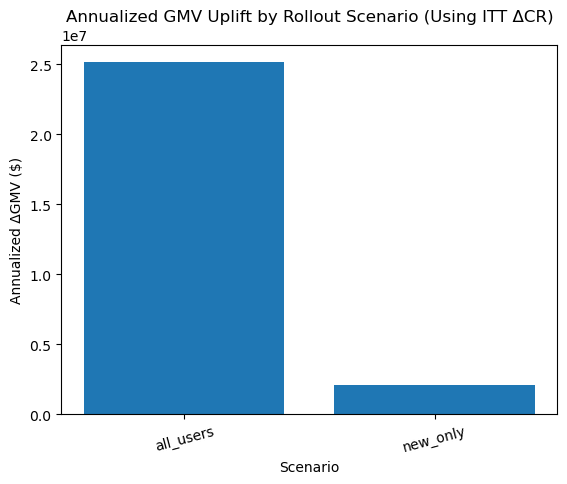

In [9]:
# 7.2 Incremental GMV（×AOV，年化）+ 图表

import matplotlib.pyplot as plt

gmv_df = orders_df.copy()
gmv_df["AOV"] = AOV
gmv_df["delta_GMV_in_window"] = gmv_df["delta_orders_in_window"] * AOV
gmv_df["annualized_delta_GMV"] = gmv_df["annualized_delta_orders"] * AOV

gmv_df["annualized_GMV_CI_low"] = gmv_df["delta_orders_CI_low"] * ANNUALIZE_FACTOR * AOV
gmv_df["annualized_GMV_CI_high"] = gmv_df["delta_orders_CI_high"] * ANNUALIZE_FACTOR * AOV

display(gmv_df[[
    "scenario","N_users_in_window","delta_orders_in_window","annualized_delta_orders",
    "delta_GMV_in_window","annualized_delta_GMV","annualized_GMV_CI_low","annualized_GMV_CI_high"
]])

# Plot annualized GMV uplift (point estimate)
plt.figure()
plt.bar(gmv_df["scenario"], gmv_df["annualized_delta_GMV"])
plt.title("Annualized GMV Uplift by Rollout Scenario (Using ITT ΔCR)")
plt.xlabel("Scenario")
plt.ylabel("Annualized ΔGMV ($)")
plt.xticks(rotation=15)
plt.show()


In [11]:
# 7.3 Cost Sensitivity（best/base/worst）+ ROI 表

cost_cases = pd.DataFrame([
    {"cost_case": "best", "annual_cost": COST_BEST},
    {"cost_case": "base", "annual_cost": COST_BASE},
    {"cost_case": "worst", "annual_cost": COST_WORST},
])

roi_rows = []
for _, row in gmv_df.iterrows():
    for _, c in cost_cases.iterrows():
        roi = row["annualized_delta_GMV"] - c["annual_cost"]
        roi_rows.append({
            "scenario": row["scenario"],
            "cost_case": c["cost_case"],
            "annualized_delta_GMV": row["annualized_delta_GMV"],
            "annual_cost": c["annual_cost"],
            "annual_ROI": roi
        })

roi_df = pd.DataFrame(roi_rows)
roi_df = roi_df.sort_values(["scenario","cost_case"])
roi_df


,scenario,cost_case,annualized_delta_GMV,annual_cost,annual_ROI
1,all_users,base,2.515259e+07,80000,2.507259e+07
0,all_users,best,2.515259e+07,20000,2.513259e+07
2,all_users,worst,2.515259e+07,200000,2.495259e+07
4,new_only,base,2.079117e+06,80000,1.999117e+06
3,new_only,best,2.079117e+06,20000,2.059117e+06
5,new_only,worst,2.079117e+06,200000,1.879117e+06


In [12]:
# 7.4 Rollout Plan（10% → 50% → 100%）

rollout_doc = f"""
## Phase 7 — ROI & Rollout Decision (Checkout UI)

### ROI Summary
- Data window: {WINDOW_DAYS} days (annualize factor = {ANNUALIZE_FACTOR:.2f})
- AOV assumption: ${AOV:.2f}
- Uplift source: ITT ΔCR from exposure-aware offline A/B (Phase 6)

### Recommended Rollout
**Stage 1 — 10% (Canary)**
- Goal: system stability + metric direction check
- Guardrails: error rate / latency / checkout drop-off must not worsen
- Decision: proceed if ITT ΔCR is positive and guardrails stable

**Stage 2 — 50% (Scale Validation)**
- Goal: validate effect persistence at larger scale
- Monitor: CR, checkout funnel, SRM, segment splits (New vs Returning)
- Decision: proceed if ΔCR remains positive and consistent

**Stage 3 — 100% (Full Rollout)**
- Goal: full deployment
- Continue monitoring weekly: CR / GMV / segment heterogeneity

### Stop Conditions (Rollback)
- Guardrail regression (latency/error/spike)
- SRM anomaly after rollout
- ΔCR turns negative beyond noise for 2 consecutive checks
"""
print(rollout_doc)



## Phase 7 — ROI & Rollout Decision (Checkout UI)

### ROI Summary
- Data window: 30 days (annualize factor = 12.17)
- AOV assumption: $80.00
- Uplift source: ITT ΔCR from exposure-aware offline A/B (Phase 6)

### Recommended Rollout
**Stage 1 — 10% (Canary)**
- Goal: system stability + metric direction check
- Guardrails: error rate / latency / checkout drop-off must not worsen
- Decision: proceed if ITT ΔCR is positive and guardrails stable

**Stage 2 — 50% (Scale Validation)**
- Goal: validate effect persistence at larger scale
- Monitor: CR, checkout funnel, SRM, segment splits (New vs Returning)
- Decision: proceed if ΔCR remains positive and consistent

**Stage 3 — 100% (Full Rollout)**
- Goal: full deployment
- Continue monitoring weekly: CR / GMV / segment heterogeneity

### Stop Conditions (Rollback)
- Guardrail regression (latency/error/spike)
- SRM anomaly after rollout
- ΔCR turns negative beyond noise for 2 consecutive checks

